# Homography and Image Stitching
### 0. Package Installation

In [1]:
!pip install numpy
!pip install opencv-python
!pip install matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
import math

print("numpy version : ",np.__version__)
print("opencv version : ",cv2.__version__)

numpy version :  1.20.3
opencv version :  4.5.5


### 1. Taking Panoramic Pictures

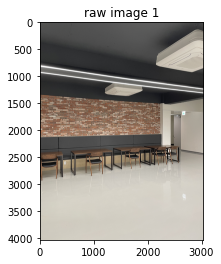

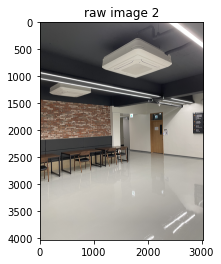

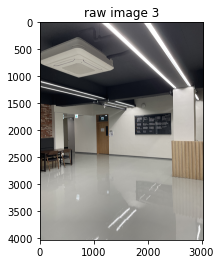

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename), cv2.IMREAD_COLOR)
        if img is not None:
            images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    images = np.array(images)
    return images

folder = "./data/"
raw_images = load_images_from_folder(folder)
for i, image in enumerate(raw_images):
    plt.imshow(image, cmap='gray')
    plt.title(("raw image " + str(i + 1)))
    plt.show()

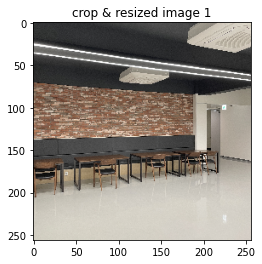

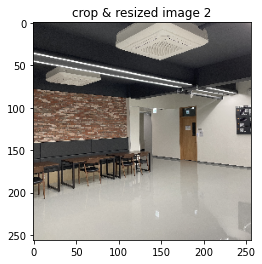

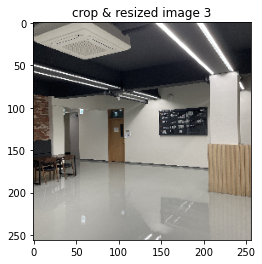

In [4]:
def crop_and_resize_images(raw_images):
    H, W, _ = raw_images[0].shape
    img_size = min(H, W)
    H_s = int((H-img_size)/2)
    H_e = int((H+img_size)/2)
    W_s = int((W-img_size)/2)
    W_e = int((W+img_size)/2)
    images = []
    for image in raw_images:
        crop_img = image[H_s:H_e, W_s:W_e]
        resize_img = cv2.resize(crop_img, (256, 256), cv2.INTER_AREA)
        images.append(resize_img)
    images = np.array(images)
    return images

images = crop_and_resize_images(raw_images)
for i, image in enumerate(images):
    plt.imshow(image, cmap='gray')
    plt.title(("crop & resized image " + str(i + 1)))
    plt.show()

### 2. Feature Extraction

The numbers of feature points are : 
270 266 270


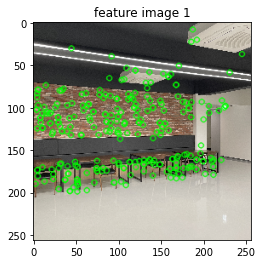

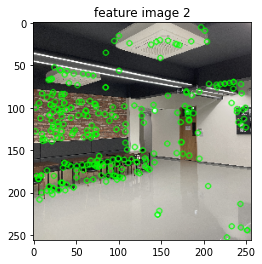

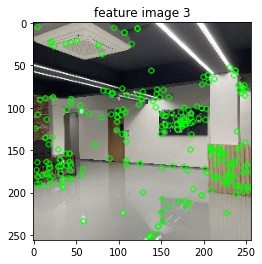

In [5]:
def detect_feature_points(images):
    sift = cv2.SIFT_create(nfeatures=270, contrastThreshold=0.02)
    keypoints = []
    descriptors = []
    for image in images:
        gray_img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        kp, des = sift.detectAndCompute(gray_img, None)
        keypoints.append(kp)
        descriptors.append(des)
    return keypoints, descriptors

kps, dess = detect_feature_points(images)
print("The numbers of feature points are : ")
print(len(dess[0]), len(dess[1]), len(dess[2]))
for i in range(len(images)):
    plt.title(("feature image " + str(i + 1)))
    plt.imshow(cv2.drawKeypoints(images[i], kps[i], None, color=(0,255,0)))
    plt.show()

### 3. Feature Matching

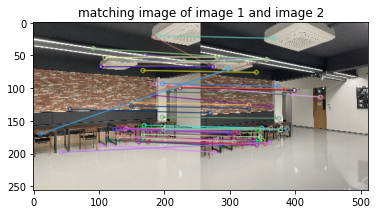

number of correspondence is : 46


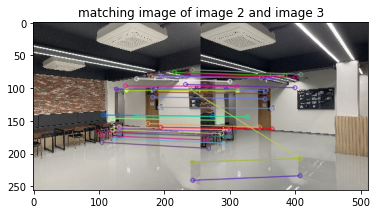

number of correspondence is : 32


In [6]:
def brute_force_matching(imgA, imgB, kpA, kpB, desA, desB, ratio):
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desA, desB, k=2)
    good_matches = []
    for m,n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)
    img3 = cv2.drawMatches(imgA, kpA, imgB, kpB, good_matches, None,
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    return img3, good_matches

ratio = 0.75
good_matches = []
for i in range(len(images) - 1):
    img, good_match = brute_force_matching(images[i], images[i + 1],
                               kps[i], kps[i + 1], dess[i], dess[i + 1], ratio)
    good_matches.append(good_match)
    plt.imshow(img)
    plt.title(("matching image of image " + str(i + 1) + " and image " + str(i + 2)))
    plt.show()
    print("number of correspondence is :", len(good_match))

### 4. Homography Estimation using RANSAC

In [7]:
def DLT(kpsA, kpsB, desA, desB, matches):
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    if len(matches) >= 4:
        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        A = []
        for i in range(len(ptsA)):
            X_i = ptsA[i]
            X_j = ptsB[i]
            A.append([0, 0, 0, -X_i[0], -X_i[1], -1, X_j[1]*X_i[0], X_j[1]*X_i[0], X_j[1]])
            A.append([X_i[0], X_i[1], 1, 0, 0, 0, -X_j[0]*X_i[0], -X_j[0]*X_i[1], -X_j[0]])
        H = np.array(A)
        U, S, VT = np.linalg.svd(A, full_matrices=True)
        h = np.transpose(VT)[:,8]
        H = np.reshape(h, (3,3))
    return H

In [8]:
def correspondence(kpsA, kpsB, matches):
    corrs = []
    for match in matches:
        (x1, y1) = kpsA[match.queryIdx].pt
        (x2, y2) = kpsB[match.trainIdx].pt
        corrs.append([x1, y1, x2, y2])
    return corrs

def symmetric_transfer_error(corr, H):
    p1 = np.transpose(np.matrix([corr[0], corr[1], 1]))
    projection_p2 = np.dot(H, p1)
    projection_p2 = (1/projection_p2.item(2))*projection_p2
    p2 = np.transpose(np.matrix([corr[2], corr[3], 1]))
    projection_p1 = np.dot(np.linalg.inv(H), p2)
    projection_p1 = (1/projection_p1.item(2))*projection_p1
    error2 = p2 - projection_p2
    error1 = p1 - projection_p1
    return np.linalg.norm(error1)**2 + np.linalg.norm(error2)**2

def total_symmetric_transfer_error(corrs, H):
    total_error = 0
    for corr in corrs:
        total_error = total_error + symmetric_transfer_error(corr, H)
    return total_error

H = DLT(kps[0], kps[1], dess[0], dess[1], good_matches[0])
print("Homography matrix of image 1 & 2")
print(H)
total_error = total_symmetric_transfer_error(correspondence(kps[0], kps[1], good_matches[0]), H)
print("total symmetric transfer error is :", total_error)

Homography matrix of image 1 & 2
[[-2.31780361e-03 -1.81312715e-03  4.88136434e-01]
 [-5.30335513e-03 -1.92370708e-03  8.72733845e-01]
 [-1.80369324e-05 -1.95949639e-05  4.23924366e-03]]
total symmetric transfer error is : 4934514.383146766


Homography matrix of image  1 & 2 with RANSAC
[[ 1.08409764e-02  1.77726783e-04 -9.79959805e-01]
 [ 1.38915641e-03  9.54299942e-03 -1.98527564e-01]
 [ 1.29594525e-05 -2.19446837e-07  7.41819729e-03]]
total symmetric transfer error is : 9.895672505438906


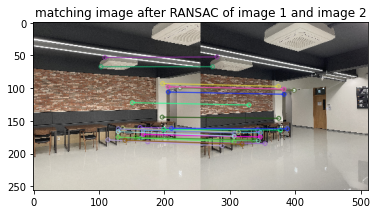

number of correspondence is : 22
total symmetric transfer error is : 9.895672505438906


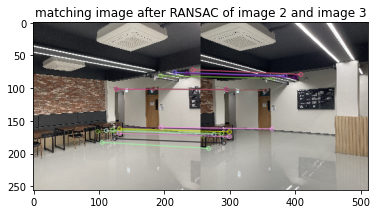

number of correspondence is : 15
total symmetric transfer error is : 9.011612454937298


In [9]:
def RANSAC(kpsA, kpsB, desA, desB, matches):
    maxInliers = []
    finalH = None
    corrs = correspondence(kpsA, kpsB, matches)
    N = 1000
    iteration = 0
    p = 0.99
    s = 4
    t = 1.25
    while iteration < N:
        sample = random.sample(range(len(corrs)), 4)
        corr = [corrs[idx] for idx in sample]
        match = [matches[idx] for idx in sample]
        h = DLT(kpsA, kpsB, desA, desB, match)
        inliers = []
        for i in range(len(corrs)):
            d = symmetric_transfer_error(corrs[i], h)
            if d < t:
                inliers.append(matches[i])
        epsilon = 1 - len(inliers)/len(corrs)
        if (len(inliers) != 0):
            N = int(math.log(1 - p)/math.log(1 - pow(1 - epsilon, s)))
        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = h
        iteration = iteration + 1
    total_error = total_symmetric_transfer_error(correspondence(kpsA, kpsB, maxInliers), finalH)
    return finalH, maxInliers, total_error

for i in range(len(images) - 1):
    H, maxInliers, total_error = RANSAC(kps[i], kps[i + 1], dess[i], dess[i + 1], good_matches[i])
    if (i == 0):
        print("Homography matrix of image ", i + 1, "&", i + 2, "with RANSAC")
        print(H)
        print("total symmetric transfer error is :", total_error)
    img_after_RANSAC = cv2.drawMatches(images[i], kps[i], images[i + 1], kps[i + 1], maxInliers, None,
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.imshow(img_after_RANSAC)
    plt.title(("matching image after RANSAC of image " + str(i + 1) + " and image " + str(i + 2)))
    plt.show()
    print("number of correspondence is :", len(maxInliers))
    print("total symmetric transfer error is :", total_error)

### 5. Warping Images

In [10]:
def black_crop(image):
    W, H, _ = image.shape
    i_min = W
    i_max = 0
    j_min = H
    j_max = 0
    for i in range(W):
        for j in range(H):
            if (sum(image[i][j]) != 0):
                i_min = min(i_min, i)
                i_max = max(i_max, i)
                j_min = min(j_min, j)
                j_max = max(j_max, j)
    result = image[i_min:i_max, j_min:j_max]
    return result

In [11]:
def warping_images(images, H):
    w, h, _ = images[0].shape
    width = 3 * w
    height = 3 * h
    imgA, imgB, imgC = images
    flip_imgA = cv2.flip(imgA, 1)
    flip_imgB = cv2.flip(imgB, 1)
    H1, H2 = H
    
    result1 = cv2.warpPerspective(imgC, np.linalg.inv(H2), (width, height))
    result1[0:w, 0:h] = imgB
    result2 = cv2.warpPerspective(flip_imgA, np.linalg.inv(H1), (width, height))
    result2[0:w, 0:h] = flip_imgB
    result2 = cv2.flip(result2, 1)
    result = cv2.hconcat([result2[0:2*w,h:int(2.5*h)], result1[0:2*w,int(0.5*h):2*h]])
    
    plt.figure(figsize=(20,10))
    plt.imshow(black_crop(result1))
    plt.title(("stitching image of image 2 & 3"))
    plt.axis('off')
    plt.show()
    plt.figure(figsize=(20,10))
    plt.imshow(black_crop(result2))
    plt.title(("stitching image of image 1 & 2"))
    plt.axis('off')
    plt.show()
    return result

### 6. Result Image

number of correspondence of image 1 & 2 is : 23
total symmetric transfer error of image 1 & 2 is : 10.64667511624226
number of correspondence of image 2 & 3 is : 16
total symmetric transfer error of image 2 & 3 is : 7.276119605220161


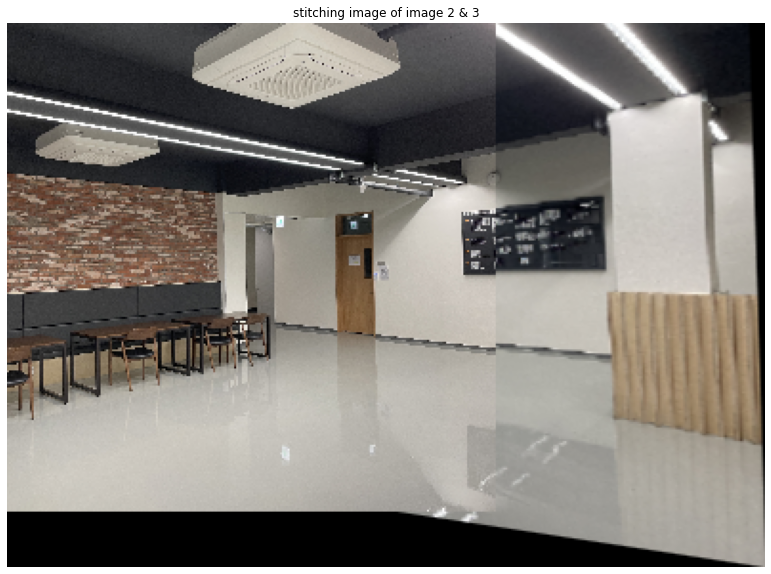

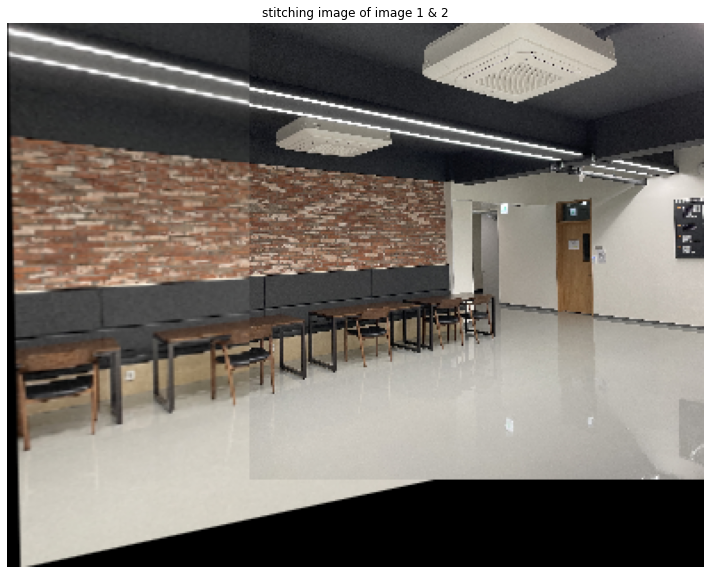

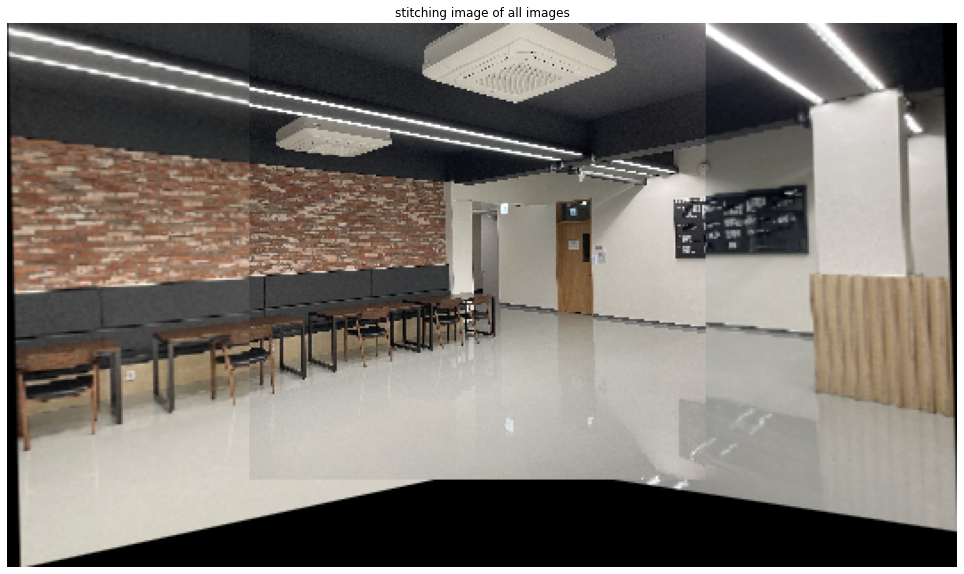

In [12]:
def homography(images):
    imgA, imgB, imgC = images
    flip_imgA = cv2.flip(imgA, 1)
    flip_imgB = cv2.flip(imgB, 1)
    
    kps, dess = detect_feature_points([flip_imgA, flip_imgB, imgB, imgC])
    
    ratio = 0.75
    _, good_matches_BA = brute_force_matching(flip_imgB, flip_imgA,
                               kps[1], kps[0], dess[1], dess[0], ratio)
    _, good_matches_BC = brute_force_matching(imgB, imgC,
                               kps[2], kps[3], dess[2], dess[3], ratio)
    good_matches = [good_matches_BA, good_matches_BC]
    H_BA, maxInliers_BA, total_error_BA = RANSAC(kps[1], kps[0], dess[1], dess[0], good_matches[0])
    H_BC, maxInliers_BC, total_error_BC = RANSAC(kps[2], kps[3], dess[2], dess[3], good_matches[1])
    H = [H_BA, H_BC]
    print("number of correspondence of image 1 & 2 is :", len(maxInliers_BA))
    print("total symmetric transfer error of image 1 & 2 is :", total_error_BA)
    print("number of correspondence of image 2 & 3 is :", len(maxInliers_BC))
    print("total symmetric transfer error of image 2 & 3 is :", total_error_BC)
    stitching_img = warping_images(images, H)
    return black_crop(stitching_img)

final_image = homography(images)
plt.figure(figsize=(20,10))
plt.imshow(final_image)
plt.title(("stitching image of all images"))
plt.axis('off')
plt.show()